In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools 
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr

from deeptime.clustering import KMeans
from deeptime.data import double_well_2d
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales 
from deeptime.plots.chapman_kolmogorov import plot_ck_test
import pyemma.coordinates
from deeptime.markov.msm import MarkovStateModel
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyinform

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [2]:
def tica(data, lagtime, var_cutoff):
    '''RETURNS: projected data on tics, tica object
    '''
    est = TICA(lagtime=lagtime, var_cutoff = var_cutoff).fit(data)
    tica = est.fetch_model()
    plt.scatter(np.arange(20),tica.singular_values[:20])
    plt.xticks(np.arange(20),np.arange(20))
    plt.title("Eigen Values")
    return tica.transform(data), tica
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

In [3]:
combined_inter = np.load("/data/asn/tica/fasudil/combined/combined_dist_matrix.npy")

In [4]:
dmat = np.load("/data/asn/tica/fasudil/dist/distance_matrix_fulL_FAS.npy")

In [5]:
combined_inter.shape

(1110889, 1727)

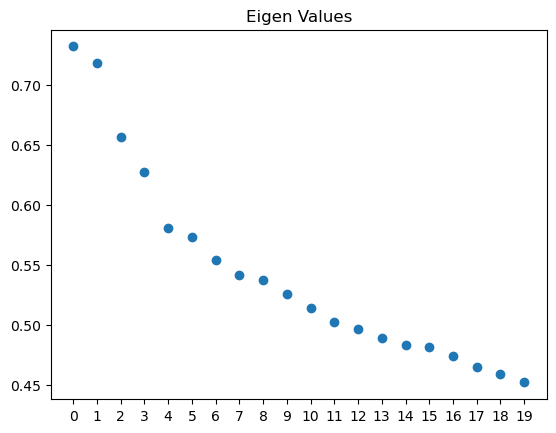

In [6]:
##adjustable params
space = 1
dim = 7
n_clusters = 200
lag = 10
##
combined = combined_inter
proj_combined, tica_combined = tica(combined,lag, .7)
#pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
#plt.figure()
#plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
#plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)

In [7]:
def fes2d(x,y,ax = None, xlabel = None,ylabel = None, cmap= 'jet',
           cbar = True, bins=150, weights=None, vmin=None,vmax=None,
           scatterx = None, scattery = None):
        z,x,y = np.histogram2d(x,y,bins=bins,weights=weights)
        extent = (x.min(), x.max(), y.min(), y.max())
        arr = np.ma.masked_array(z,z==0)
        F=-np.log(arr)
        F+=-F.min()
        if ax is None:
            fig,ax=plt.subplots(1,1,figsize=(12,12),sharex=True,sharey=True)
        if not ((scatterx is None) or (scattery is None)):
            ax.scatter(scatterx, scattery, c='grey', s=60, edgecolors='black', alpha=0.5)
        a=ax.contourf(F.T,200,cmap=cmap,extent=extent,zorder=-1, vmin=vmin, vmax=vmax)
        ax.set_xlabel(xlabel,fontsize=45)
        ax.set_ylabel(ylabel,fontsize=45)
        ax.tick_params(axis="x",labelsize=30)
        ax.tick_params(axis="y",labelsize=30)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))*1.0)
        if cbar:
            cb = plt.colorbar(a,ax=ax,fraction=0.046, pad=0.04,format="%.0f", )
            cb.set_label("Free Energy / (kT)",size=30,labelpad = 20)
            cb.ax.tick_params(labelsize = 30)
        return 

/tmp/ipykernel_29729/642772380.py:7: RuntimeWarning: divide by zero encountered in log
  F=-np.log(arr)


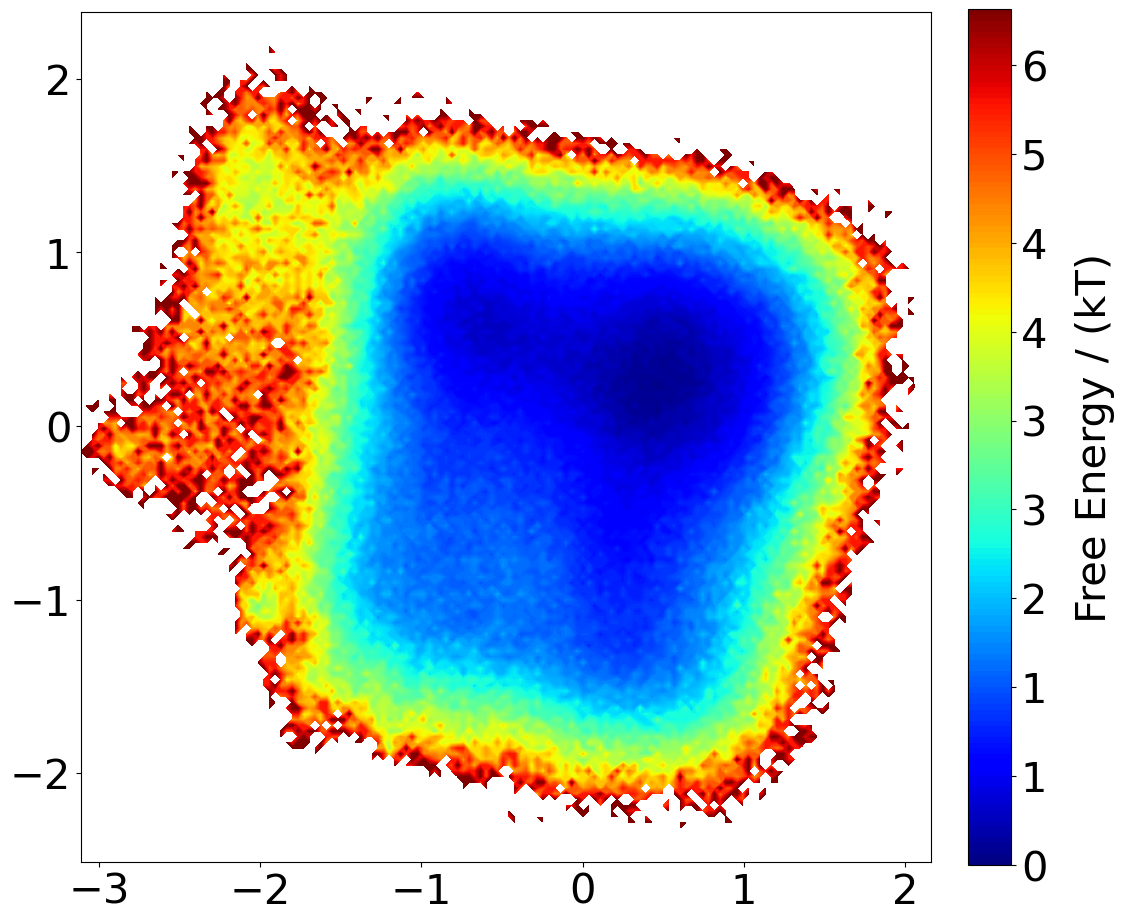

In [9]:
fes2d(proj_combined[:,0], proj_combined[:,1])

In [ ]:
models = []
lagtimes = np.arange(1, 500)
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtraj)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=4, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

In [10]:
counts = deeptime.markov.TransitionCountEstimator(lagtime=2, count_mode="effective").fit(dtraj).fetch_model()
mm = deeptime.markov.msm.BayesianMSM().fit(counts).fetch_model() 

In [8]:
models = []
for lag in [100, 150, 200, 250, 300]:
    counts_estimator = TransitionCountEstimator(lagtime=lag, count_mode='effective')
    models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(dtraj).submodel_largest()))

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


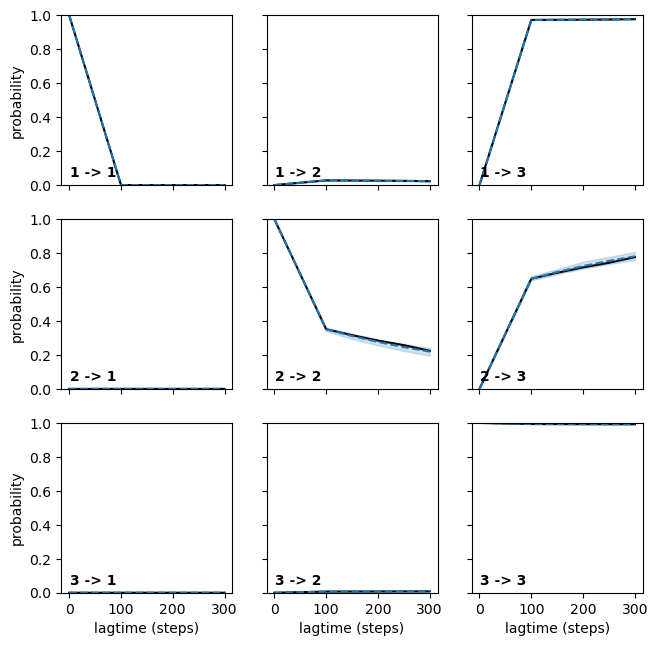

In [9]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=3)
grid = plot_ck_test(ck_test, legend=False)

In [11]:
tmat = mm.gather_stats(quantity = "transition_matrix").mean

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


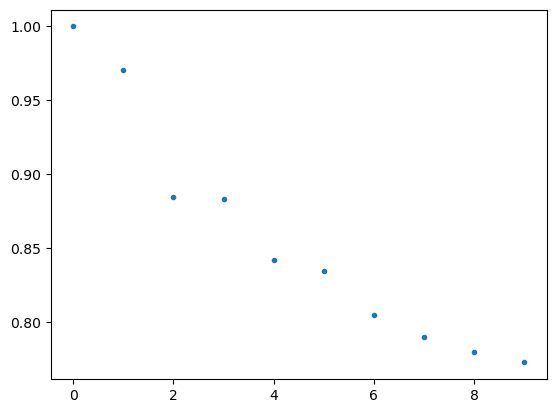

In [12]:
plt.plot(deeptime.markov.tools.analysis.eigenvalues(tmat, k=10, ncv=None, reversible=False, mu=None), '.')

In [13]:
states = 4
pcca = mm.samples[0].pcca(states)

In [14]:
pcca_tmat = pcca.coarse_grained_transition_matrix

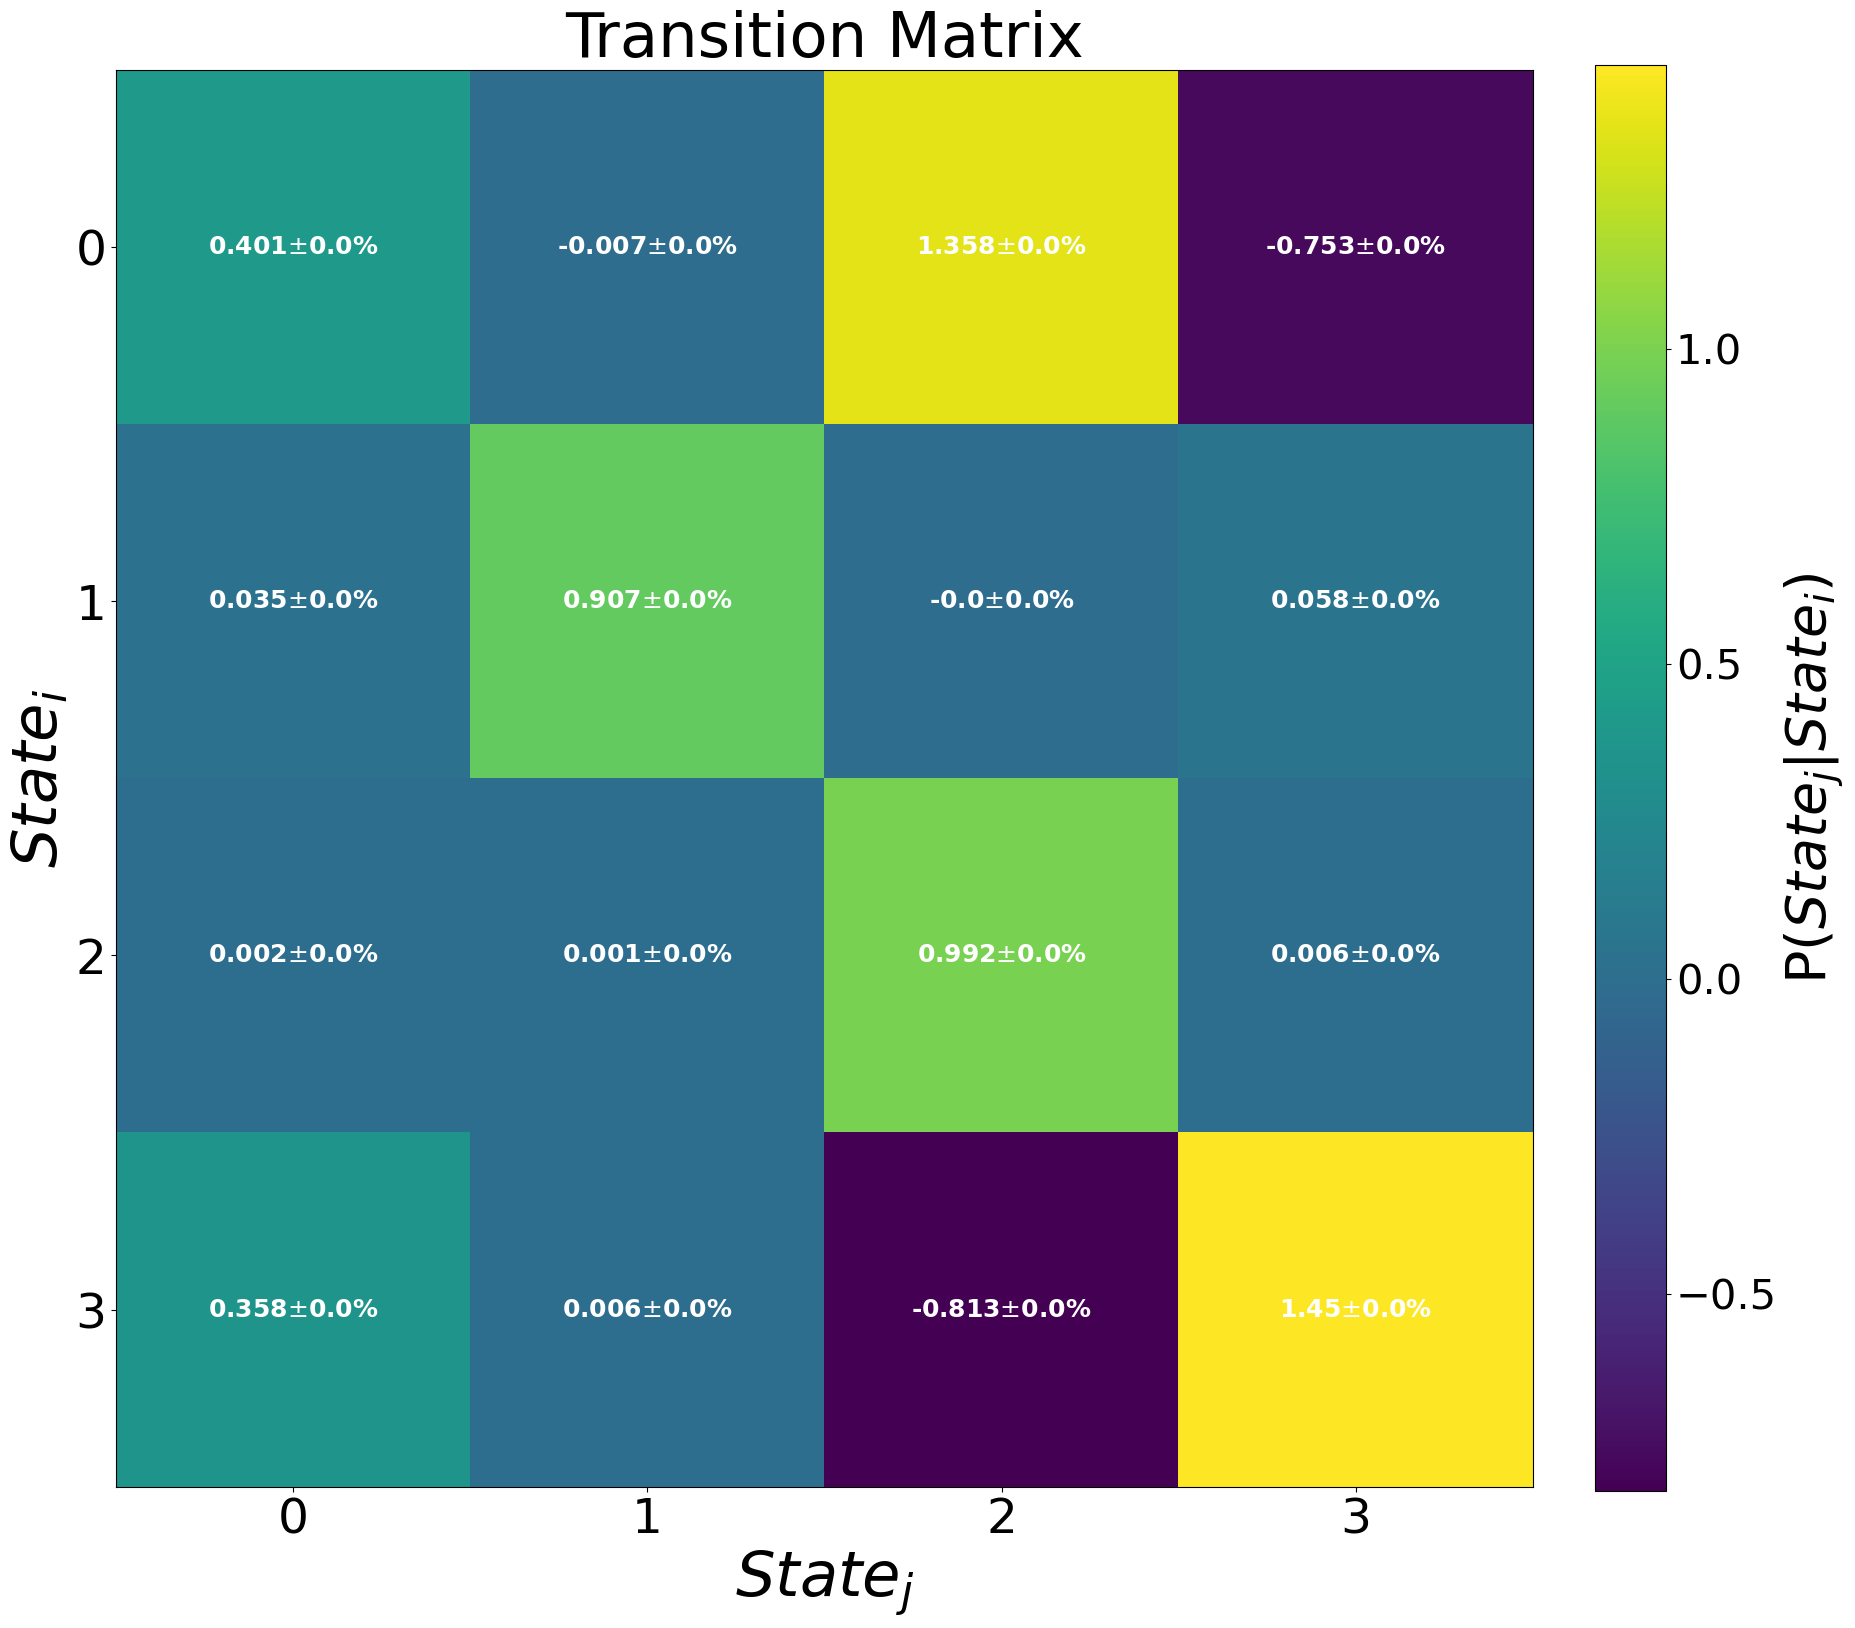

In [15]:
def plot_mat_error(mat,emat,title,unit,cbarlabel,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = ax.imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                e = emat[j,i]
                ax.text(i, j,f"{np.round(c,3)}$\pm${np.round(e,2)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.set_yticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_xticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_ylabel(r"$State_{i}$", size=45)
        ax.set_xlabel(r"$State_{j}$", size=45)
        cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        cb.set_label(cbarlabel, size=40)
        cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 45)
        plt.show()
        return

#transition matrix errors

plot_mat_error(pcca_tmat,np.zeros_like(pcca_tmat),"Transition Matrix","%",
               r"P($State_{j}$|$State_{i}$)",18,"white","viridis",np.arange(states) )

In [16]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = dtraj.max()+1
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [17]:
pcca.coarse_grained_stationary_probability*100

array([36.74612487,  1.10345212,  0.76826358, 61.38215943])

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

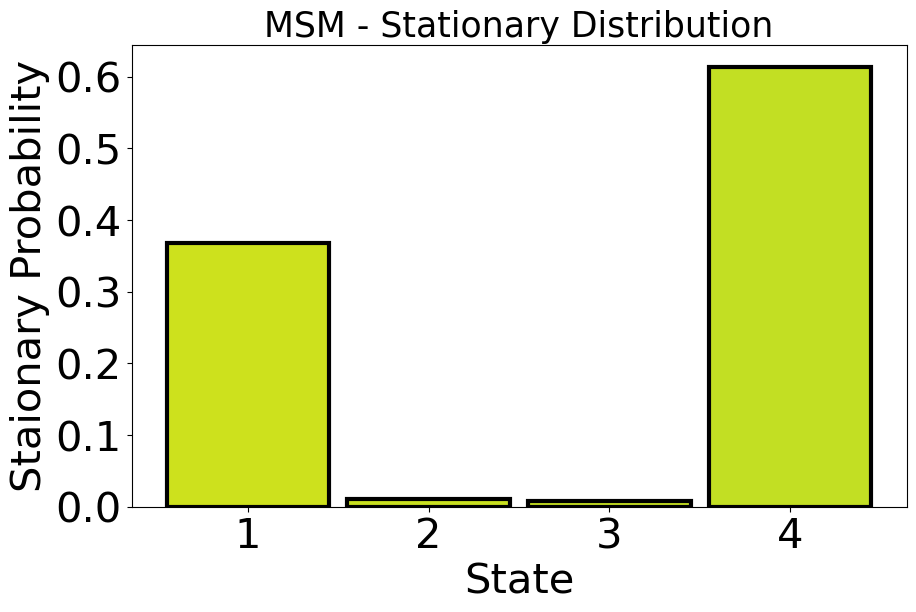

In [18]:
plt.figure(figsize = (10,6))
plt.bar(np.arange(states), pcca.coarse_grained_stationary_probability,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))
plt.xticks(np.arange(states), ticklabs)
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title("MSM - Stationary Distribution",size=25)
plt.xticks(size = 30)
plt.yticks(size = 30)
#plt.xlim(.5,states)

/tmp/ipykernel_29729/3355925826.py:4: RuntimeWarning: Mean of empty slice.
  plt.plot(dmat[i].mean(0), label = f"Cluster Fraction : {100*len(i)/len(dmat):.2f}%")
/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


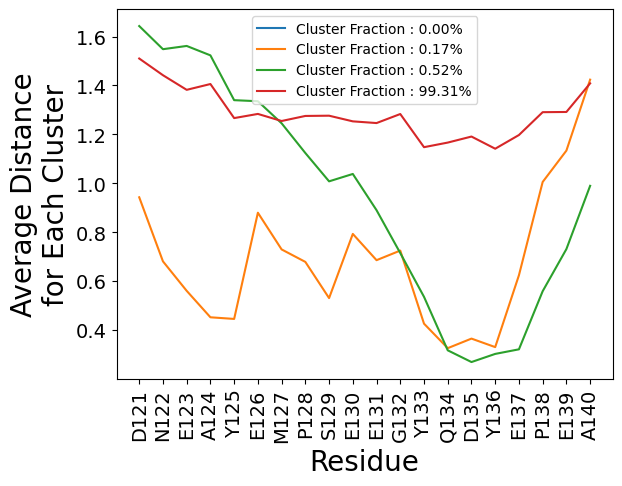

In [29]:
macro_dtraj = pcca.assignments[dtraj]
macro_frames_cl = [np.where(macro_dtraj == i)[0] for i in range(macro_dtraj.max()+1)]
for i in macro_frames_cl:
    plt.plot(dmat[i].mean(0), label = f"Cluster Fraction : {100*len(i)/len(dmat):.2f}%")
    plt.legend()
    plt.yticks(fontsize = 14)
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    plt.xlabel('Residue', fontsize = 20)
    plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

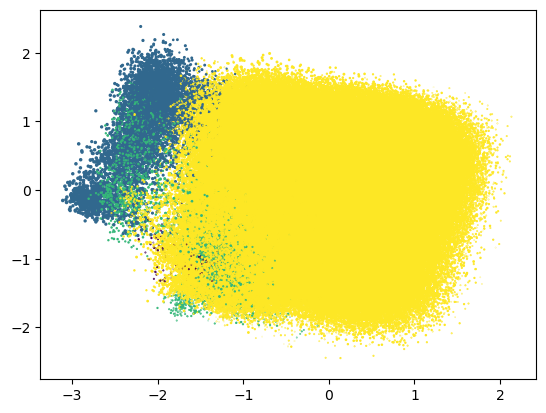

In [23]:
plt.scatter(*proj_combined[:, :3].T, c=macro_dtraj)

In [24]:
np.save('fas_pcca_macro_dtraj_4clusters.npy', macro_dtraj)

In [24]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = macro_dtraj.max()
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(1,len(cs)-1,nstates)]
clist = clist[::-1]

In [25]:
#customize pyemma source code
from pyemma.util.statistics import confidence_interval as _conf
from pyemma.util.types import is_iterable_of_int as _is_iterable_of_int, is_int as _is_int
import numpy as _np
__author__ = 'noe'


def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Should be of type :class:`ImpliedTimescales <pyemma.msm.ImpliedTimescales>`
        or a 3-tuple with: 1d array of lagtimes, (lagtimes, processes) array of timescales,
        optionally (lagtimes, processes, samples) array of timescales of samples.
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    if isinstance(ITS, tuple):
        assert len(ITS) in (2, 3)
        lags = _np.asarray(ITS[0])
        timescales = _np.asarray(ITS[1])
        timescales_samples = _np.asarray(ITS[2]) if len(ITS) == 3 and ITS[2] is not None else None
        n_timescales = timescales.shape[1]
        samples_available = timescales_samples is not None
    else:
        lags = ITS.lagtimes
        n_timescales = ITS.number_of_timescales
        timescales = ITS.get_timescales()
        samples_available = ITS.samples_available
        timescales_samples = ITS.timescales_samples
        if timescales_samples is not None:
            timescales_samples = timescales_samples.transpose(1, 2, 0)
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca(figsize= (10,6))
    colors = clist ######ADDED#####
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > n_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), n_timescales))
        # Now that it's for sure that nits==-1,
        # process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = n_timescales
        its_idx = _np.arange(n_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], timescales[..., i][srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if samples_available:
            # plot sample mean
            process_samples = timescales_samples[:, i, :].T
            if show_mean:
                sample_mean = _np.mean(process_samples, axis=0)
                ax.plot(
                    lags[srt] * dt[0], sample_mean[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            lconf, rconf = _conf(process_samples, conf=confidence)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.2, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    # show or save
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

estimating BayesianMSM:   0%|                                                                                 …

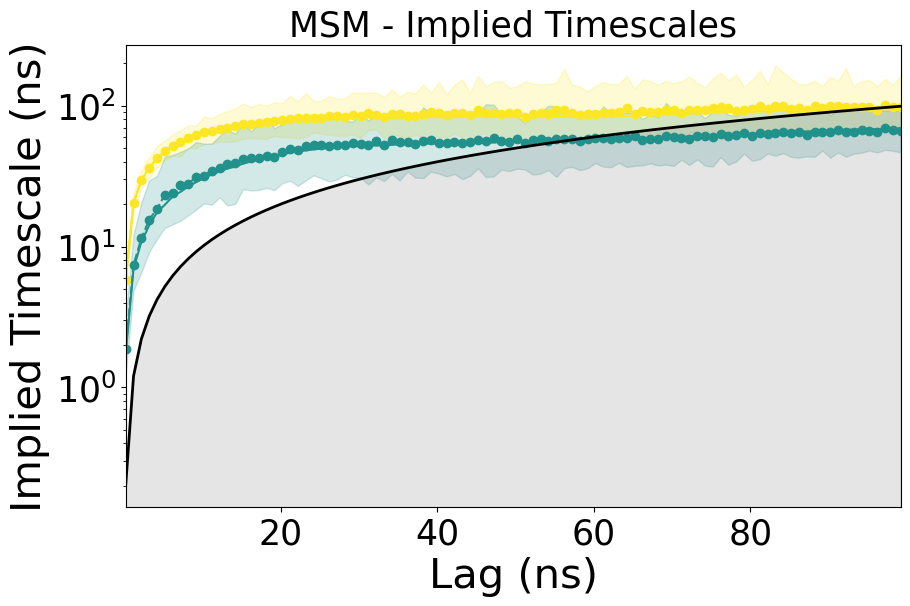

In [26]:
its = pyemma.msm.its(macro_dtraj,np.arange(1,500,5),nits=nstates-1, errors="bayes", nsamples = 100,
                    n_jobs=1, )
fig,ax = plt.subplots(1,figsize=(10,6))
plot_implied_timescales(its,units="ns", dt=.2,ax=ax)
ax.set_xlabel("Lag (ns)",size=30)
ax.set_ylabel("Implied Timescale (ns)",size=30)
ax.set_title("MSM - Implied Timescales",size=25)
ax.tick_params("both", labelsize=25)

In [27]:
lagtime = 300
bmsm = pyemma.msm.bayesian_markov_model(macro_dtraj,lagtime,nsamples=10)    
ck = bmsm.cktest(nstates-1,memberships = np.eye(nstates),n_jobs=1,)

#customize pyemma source code
def _add_ck_subplot(cktest, test_index, ax, i, j, ipos=None, jpos=None, y01=True, units='steps', dt=1., **plot_kwargs):
    # plot estimates
    for default in ['color', 'linestyle']:
        if default in plot_kwargs.keys():
            #print("ignoring plot_kwarg %s: %s"%(default, plot_kwargs[default]))
            plot_kwargs.pop(default)
    color = clist[1] ####this is added######

    lest = ax.plot(dt*cktest.lagtimes, cktest.estimates[:, i, j], color="black", **plot_kwargs)
    # plot error of estimates if available
    if cktest.has_errors and cktest.err_est:
        ax.fill_between(dt*cktest.lagtimes, cktest.estimates_conf[0][:, i, j], cktest.estimates_conf[1][:, i, j],
                        color='black', alpha=0.2)
    # plot predictions
    lpred = ax.plot(dt*cktest.lagtimes, cktest.predictions[:, i, j], color=color, linestyle='dashed', **plot_kwargs)
    # plot error of predictions if available
    if cktest.has_errors:
        ax.fill_between(dt*cktest.lagtimes, cktest.predictions_conf[0][:, i, j], cktest.predictions_conf[1][:, i, j],
                        color=color, alpha=0.2)
    # add label
    ax.text(0.1, 0.8, str(i+1)+' ->'+str(j+1), transform=ax.transAxes, weight='bold')
    if y01:
        ax.set_ylim(0, 1)
    # Axes labels
    if ipos is None:
        ipos = i
    if jpos is None:
        jpos = j
    if (jpos == 0):
        ax.set_ylabel('probability')
    if (ipos == cktest.nsets-1):
        ax.set_xlabel('lag time (' + units + ')')
    # return line objects
    return lest, lpred

def plot_cktest(cktest, figsize=None, diag=False,  y01=True, layout=None,
                padding_between=0.1, padding_top=0.075, units='steps', dt=1., **plot_kwargs):
    """Plot of Chapman-Kolmogorov test
    Parameters
    ----------
    cktest : msm.ChapmanKolmogorovValidator or list of msm.ChapmanKolmogorovValidator
        Chapman-Kolmogorov Test, optionally a list of tests which are all 
        plotted into the same set of axes. This assumes that all cktests were
        estimated for the same nstates.
    figsize : shape, default=(10, 10)
        Figure size
    diag : bool, default=False
        Plot only diagonal elements of the test, i.e. self-transition
        probabilities.
    y01 : bool, default=True
        Scale all y-Axes to [0,1]. If True, the y-Axes can be shared
        and the figure is tighter. If False, each y Axis will be scaled
        automatically.
    layout : str or shape or None, default=None
        Organization of subplots. You can specify your own shape. If None,
        an automatic shape will be selected. Use 'wide' for plots that
        span the page width (double-column figures) and 'tall' for
        single-column figures.
    padding_between : float, default=0.1
        padding space between subplots (as a fraction of 1.0)
    padding_top : float, default=0.05
        padding space on top of subplots (as a fraction of 1.0)
    **plot_kwargs : optional keyword arguments for the matplotlib.pylab.plot() call
        The user is allowed to choose values like marker='x', linewidth=3 etc. Note that
        'linestyle' and 'color' are defaults and cannot be changed using plot_kwargs
    Returns
    -------
    fig : Figure object
    axes : Axis objects with subplots
    """
    if not isinstance(cktest, (list, tuple)):
        cktests = [cktest]
    else:
        cktests = cktest
    cktest = cktests[0]
    for test in cktests:
        assert cktest.nsets == test.nsets, "cktests all need same number of sets"
    import matplotlib.pylab as plt
    sharey = y01
    # first fix subfigure layout
    if diag:
        if layout is None or layout == 'wide':
            ncol = min(4, cktest.nsets)
            layout = (int(math.ceil(cktest.nsets / ncol)), ncol)
        elif layout == 'tall':
            nrow = min(4, cktest.nsets)
            layout = (nrow, int(math.ceil(cktest.nsets / nrow)))
    else:
        layout = (cktest.nsets, cktest.nsets)
    # fix figure size
    if figsize is None:
        size_per_subplot = min(3.0, 10.0 / np.max(np.array(layout)))
        figsize = (size_per_subplot*layout[1], size_per_subplot*layout[0])
    # generate subplots
    fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)
    axeslist = list(axes.flatten())
    # line objects
    lest = None
    lpred = None
    # plot
    lests = []
    lpreds = []
    for test_index, test in enumerate(cktests):
        for (k, ax) in enumerate(axeslist):
            if diag and k < cktest.nsets:
                ipos = int(k/layout[1])
                jpos = int(k%layout[1])
                lest, lpred = _add_ck_subplot(test, test_index, ax, k, k, ipos=ipos, jpos=jpos, y01=y01, units=units,
                                              dt=dt, **plot_kwargs)
                k += 1
            else:
                i = int(k/cktest.nsets)
                j = int(k%cktest.nsets)
                lest, lpred = _add_ck_subplot(test, test_index, ax, i, j, y01=y01, units=units, dt=dt, **plot_kwargs)
        lests.append(lest[0])
        lpreds.append(lpred[0])
    # figure legend
    handles = []
    labels = []
    for ix, test in enumerate(cktests):
        predlabel = 'predict {}'.format(ix) if len(cktests) > 1 else 'predict'
        estlabel = 'estimate {}'.format(ix) if len(cktests) > 1 else 'estimate'
        if cktest.has_errors:
            predlabel += '     conf. {:3.1f}%'.format(100.0*cktest.conf)
        handles.append(lests[ix])
        handles.append(lpreds[ix])
        labels.append(predlabel)
        labels.append(estlabel)
    fig.legend(handles, labels, 'upper center', ncol=2, frameon=False,prop={'size': 15})
    # change subplot padding
    plt.subplots_adjust(top=1.0-padding_top, wspace=padding_between, hspace=padding_between)
    # done
    return fig, axes

pyemma.msm.estimators.bayesian_msm.BayesianMSM[202]: Sampling MSMs:   0%|                                     …

estimating BayesianMSM:   0%|                                                                                 …

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


Text(0.03, 0.5, 'Probability')

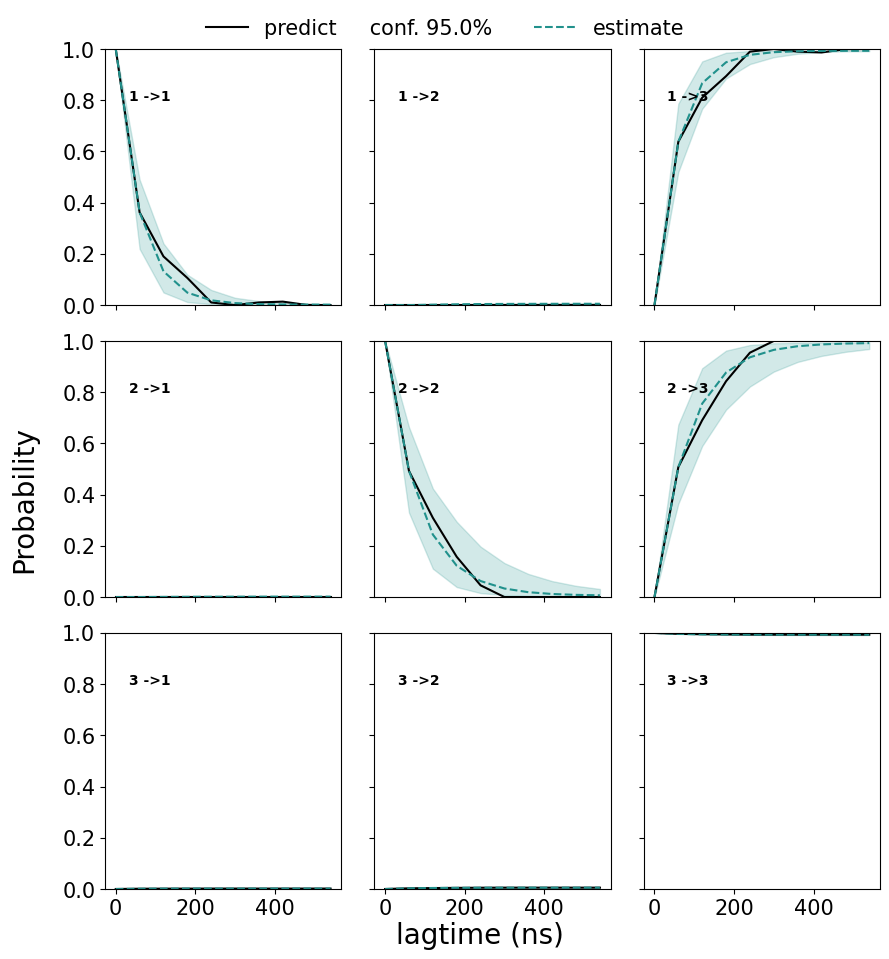

In [28]:
#plot customized CK plot
fig, ax =plot_cktest(ck,figsize=(10,10),padding_top= .05,units = "ns", dt = .2,
                                  padding_between = 0.14, y01=True,layout="wide")
for axi in ax.flat:
    axi.set_xlabel(None)
    axi.set_ylabel(None)
    axi.tick_params(axis="both",labelsize=15)
    #axi.tick_params(axis="y",labelsize=10)
fig.supxlabel("lagtime (ns)",x=0.5,y=.05,size = 20)
fig.supylabel("Probability",x=.03,y=.5,size = 20)